<a href="https://colab.research.google.com/github/Aabha-J/Pytorch/blob/main/Tiny_VGG_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

#Get Data

In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    file_name = "pizza_steak_sushi.zip"

    with open(data_path / file_name, "wb") as f:
        request = requests.get(url)
        print("Downloading")
        f.write(request.content)

    with zipfile.ZipFile(data_path / file_name, "r") as zip_ref:
        print(f"Unzipping {file_name}")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Downloading
Unzipping pizza_steak_sushi.zip


In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [4]:
train_dir = image_path/"train"
test_dir = image_path/"test"

#Model 0

##Process Data

In [5]:
import os
from PIL import Image

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
model0_transform = transforms.Compose([transforms.Resize(size = (64, 64)), transforms.ToTensor()])

train_dir = image_path / "train"
test_dir = image_path / "test"

train_data_0 = datasets.ImageFolder(root = train_dir,
                                 transform = model0_transform,
                                 target_transform = None)

test_data_0 = datasets.ImageFolder(root = test_dir,
                                 transform = model0_transform,
                                 target_transform=None)

WORKERS, BATCH_SIZE = os.cpu_count(), 32

train_dataloader_0 = DataLoader(dataset = train_data_0, batch_size = BATCH_SIZE,
                                shuffle = True, num_workers = WORKERS)

test_dataloader_0 = DataLoader(dataset = test_data_0, batch_size = BATCH_SIZE,
                                shuffle = False, num_workers = WORKERS)

class_names = train_data_0.classes
class_dict = train_data_0.class_to_idx

##Model Class
- Tiny VGG Model

In [8]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [9]:
model_0 = TinyVGG(input_shape= 3, hidden_units=10, output_shape=3)

###Torch Info

In [10]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


In [11]:
summary(model_0, [1,3,64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

##Training and Testing

###Training and Testing Functions

In [18]:
from torch import optim
from tqdm.auto import tqdm

In [14]:
def train(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: optim.Optimizer
               ):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    model.train()

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ##accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim =1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_acc /= len(dataloader)
  train_loss /= len(dataloader)


  return train_loss, train_acc

def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module):
  test_acc, test_loss = 0, 0

  model.to(device)
  model.eval()

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_class = torch.argmax(test_pred_logits, dim =1)
      test_acc += (test_pred_class == y).sum().item()/len(test_pred_class)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)


  return test_loss, test_acc



###Training & Testing Loop

In [15]:
def train_test_loop(model: torch.nn.Module,
               train__dataloader: torch.utils.data.DataLoader,
               test__dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               epochs: int ):
  model.to(device)


  results = {"train loss":[], "train acc":[], "test loss": [], "test acc":[] }
  for epoch in tqdm(range(epochs)):

      train_loss, train_acc = train(model, train__dataloader, loss_fn, optimizer)
      test_loss, test_acc = test(model, test__dataloader,loss_fn)

      results["train loss"].append(train_loss)
      results["train acc"].append(train_acc)
      results["test acc"].append(test_acc)
      results["test loss"].append(test_loss)

  return results

###Loss and Optimizer Function

In [16]:
  optimizer = optim.Adam(params = model_0.parameters(), lr = 0.001)
  loss_fn = nn.CrossEntropyLoss()
  EPOCHS = 11

In [19]:
model_0_results = train_test_loop(model_0, train_dataloader_0, test_dataloader_0,optimizer, loss_fn, EPOCHS)

  0%|          | 0/11 [00:00<?, ?it/s]

###Plot Loss Curves

In [25]:
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, list[float]]):
  loss = results['train loss']
  test_loss = results['test acc']

  acc = results["train acc"]
  test_acc = results["test acc"]

  epochs = range(len(results["train acc"]))

  plt.figure(figsize=(10, 5))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = "Train Loss")
  plt.plot(epochs, test_loss, label = "Test Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label = 'Train Accuracy')
  plt.plot(epochs, test_acc, label = 'Test Accuracy')
  plt.title("Accuracy")
  plt.xlabel("Epochs")

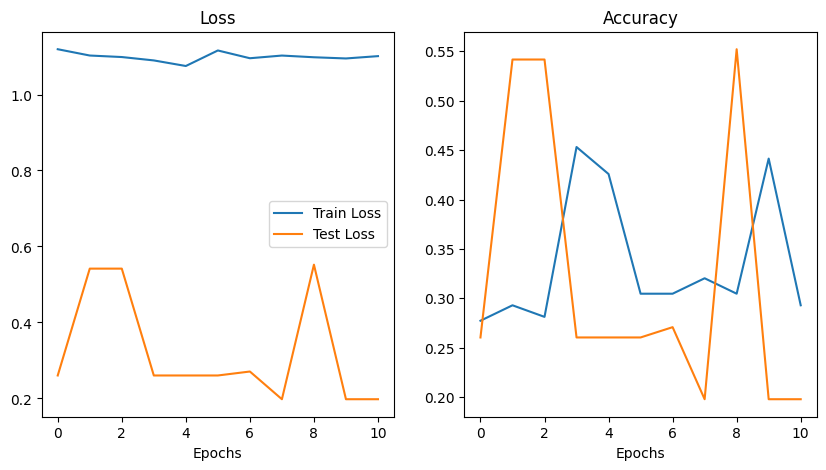

In [26]:
plot_loss_curves(model_0_results)

#Model 1: Tiny VGG with Data Augmentation

##Data Processing

In [27]:
train_transform_1 = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform_1 = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

train_data_1 = datasets.ImageFolder(root = train_dir,
                                 transform = train_transform_1,
                                 target_transform = None)

test_data_1 = datasets.ImageFolder(root = test_dir,
                                 transform = test_transform_1,
                                 target_transform=None)


train_dataloader_1 = DataLoader(dataset = train_data_1,
                              batch_size = 32,
                              num_workers = os.cpu_count(),
                              shuffle = True)

test_dataloader_1 = DataLoader(dataset=test_data_1, batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [29]:
model_1 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape = 3)

##Train & Test

In [30]:
optimizer = optim.Adam(params = model_1.parameters(), lr = 0.001)
loss_fn = nn.CrossEntropyLoss()


model_1_results = train_test_loop(model = model_1,
                             train__dataloader=train_dataloader_1,
                             test__dataloader=test_dataloader_1,
                             optimizer = optimizer,
                             loss_fn = loss_fn, epochs = EPOCHS)

  0%|          | 0/11 [00:00<?, ?it/s]

#Compare Models with Pandas and Matplotlib

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

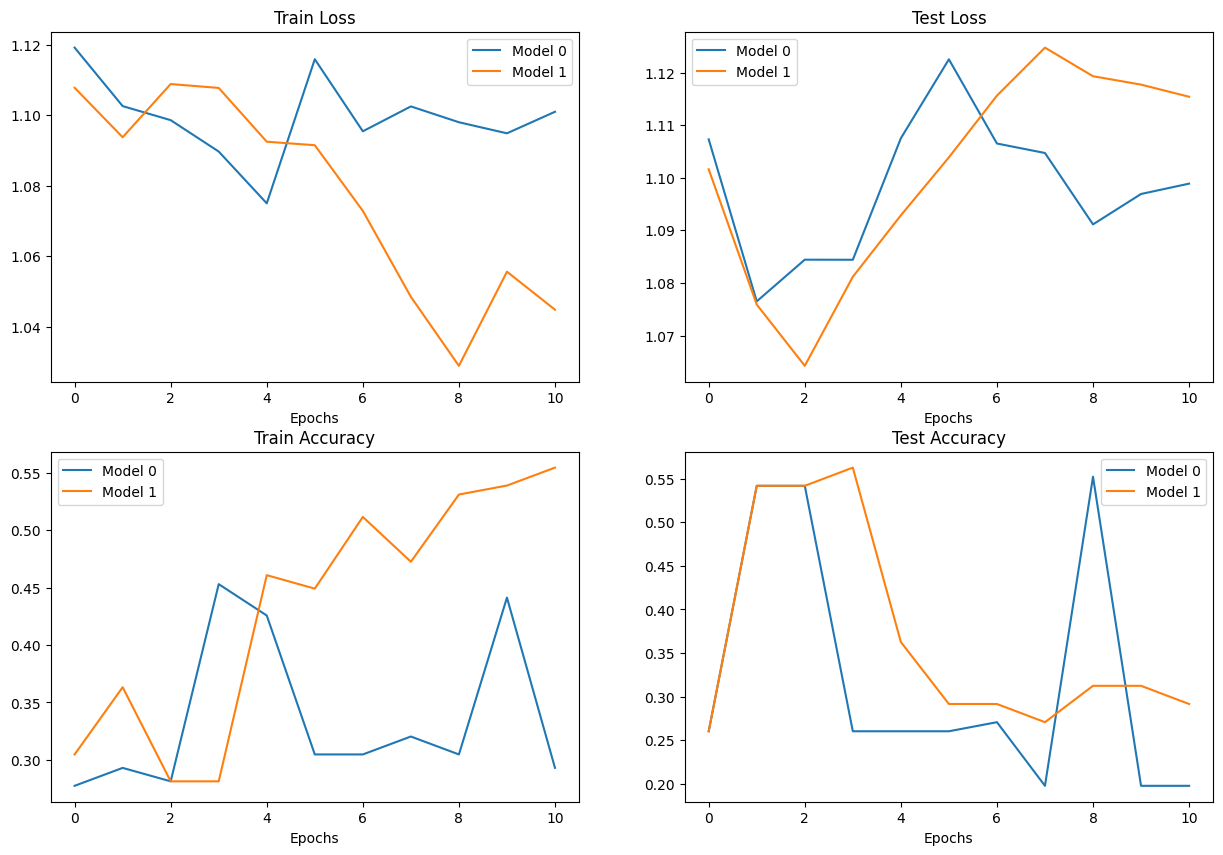

In [34]:
plt.figure(figsize = (15, 10))
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train loss"], label = 'Model 0')
plt.plot(epochs, model_1_df["train loss"], label = 'Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()


plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test loss"], label = 'Model 0')
plt.plot(epochs, model_1_df["test loss"], label = 'Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train acc"], label = 'Model 0')
plt.plot(epochs, model_1_df["train acc"], label = 'Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()


plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test acc"], label = 'Model 0')
plt.plot(epochs, model_1_df["test acc"], label = 'Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()